In [2]:
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import numpy as np
import pandas as pd
import nltk
import string
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import classification_report,confusion_matrix
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os
!pip install -q scikit-plot
import scikitplot.metrics as skplt
import sqlite3
from google.colab import drive 
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
os.chdir("/content/drive/My Drive/Colab Notebooks")


In [0]:
con = sqlite3.connect("final.sqlite")

In [0]:
import pandas as pd
filtered_data = pd.read_sql_query("""
SELECT * FROM REVIEWS
""",con)

In [6]:
filtered_data.shape

(364171, 12)

In [0]:
filtered_data.set_index = filtered_data.index

In [0]:
filtered_data.drop(['index'],axis=1)
#dropping index value from columns

In [0]:
final_data = filtered_data.sample(60000,random_state=2)

#sampling 100k datapoints

In [0]:
final_data.head(3)
final_data = final_data.sort_values('Time')

In [11]:

final_data.Score.value_counts()

positive    50677
negative     9323
Name: Score, dtype: int64

In [0]:
final_data.head(3)

In [0]:
final_data_kd_tree  = final_data.sample(20000,random_state=2)
#sampling 20 k points for kd_tree

In [14]:
final_data_kd_tree.Score.value_counts()

positive    16882
negative     3118
Name: Score, dtype: int64

# KNN on AVG W2V using KD_tree

In [0]:
#traning own model
i=0
list_of_sent=[]
for sent in filtered_data['CleanedText'].values:
    list_of_sent.append(sent.split())

In [0]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50,workers=4)

In [0]:
w2v_words = list(w2v_model.wv.vocab)

In [18]:
w2v_model.wv.most_similar('tasti')

[('delici', 0.8092088103294373),
 ('yummi', 0.7842735052108765),
 ('tastey', 0.7792528867721558),
 ('hearti', 0.6838183403015137),
 ('nutriti', 0.6770579218864441),
 ('satisfi', 0.6765849590301514),
 ('good', 0.6748582720756531),
 ('nice', 0.6626357436180115),
 ('terrif', 0.6532567143440247),
 ('crunchi', 0.6260974407196045)]

In [0]:
X = final_data_kd_tree['CleanedText'].values
y = final_data_kd_tree.Score.values
X_tr, X_test, y_tr, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=0)
# split the train data set into cross validation train and cross validation test



In [21]:
#training data
i=0
list_of_sent=[]
for sent in X_tr:
    list_of_sent.append(sent.split())
    
#Avgw2v
sent_vectors = []
for sent in tqdm(list_of_sent):
    sent_vec = np.zeros(50)
    cnt_words=0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

100%|██████████| 14000/14000 [00:29<00:00, 478.08it/s]


In [33]:
X_tr = sent_vectors

print(len(list_of_sent),len(X_tr))

14000 14000


In [34]:
#test data
#Avgw2v
i=0
list_of_sent=[]
for sent in X_test:
    list_of_sent.append(sent.split())
    
#Avgw2v
sent_vectors = []
for sent in tqdm(list_of_sent):
    sent_vec = np.zeros(50)
    cnt_words=0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

100%|██████████| 6000/6000 [00:12<00:00, 468.24it/s]


In [36]:
X_test = sent_vectors

print(len(list_of_sent),len(X_test))

6000 6000


In [37]:
print(len(X_tr[0]))

50



The optimal number of neighbors is 9.


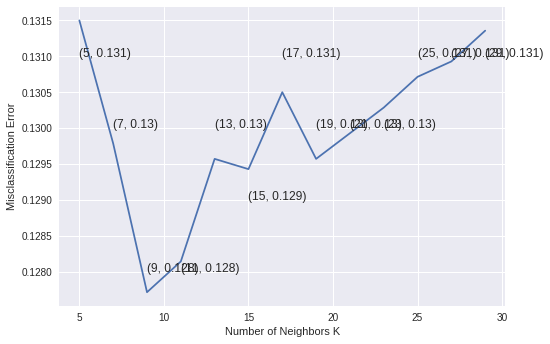

the misclassification error for each k value is :  [0.131 0.13  0.128 0.128 0.13  0.129 0.131 0.13  0.13  0.13  0.131 0.131
 0.131]


In [39]:
#Finding optimal k
# creating odd list of K for KNN
myList = list(range(5,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 2-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    scores = cross_val_score(knn, X_tr, y_tr, cv=2, scoring='f1_micro')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [40]:
#Performing KNN using kd_tree
knn = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
knn.fit(X_tr,y_tr)
pred = knn.predict(X_test)
acc = f1_score(y_test, pred,average='micro') * float(100)
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 9 is 87.183333%


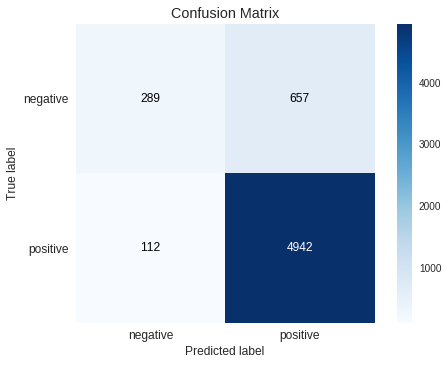

In [41]:
skplt.plot_confusion_matrix(y_test ,pred)

In [42]:
from sklearn.metrics import classification_report
print(classification_report(y_test ,pred))

              precision    recall  f1-score   support

    negative       0.72      0.31      0.43       946
    positive       0.88      0.98      0.93      5054

   micro avg       0.87      0.87      0.87      6000
   macro avg       0.80      0.64      0.68      6000
weighted avg       0.86      0.87      0.85      6000



# KNN on AVG W2V using Brute Force

In [0]:
X = final_data['CleanedText'].values
y = final_data.Score.values
X_tr, X_test, y_tr, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=0)
# split the train data set into cross validation train and cross validation test



In [44]:
#training data
i=0
list_of_sent=[]
for sent in X_tr:
    list_of_sent.append(sent.split())
    
#Avgw2v
sent_vectors = []
for sent in tqdm(list_of_sent):
    sent_vec = np.zeros(50)
    cnt_words=0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

100%|██████████| 42000/42000 [01:28<00:00, 476.39it/s]


In [45]:
X_tr = sent_vectors

print(len(list_of_sent),len(X_tr))

42000 42000


In [46]:
#test data
#Avgw2v
i=0
list_of_sent=[]
for sent in X_test:
    list_of_sent.append(sent.split())
    
#Avgw2v
sent_vectors = []
for sent in tqdm(list_of_sent):
    sent_vec = np.zeros(50)
    cnt_words=0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

100%|██████████| 18000/18000 [00:37<00:00, 482.83it/s]


In [47]:
X_test = sent_vectors

print(len(list_of_sent),len(X_test))

18000 18000


In [48]:
print(len(X_tr[0]))

50



The optimal number of neighbors is 11.


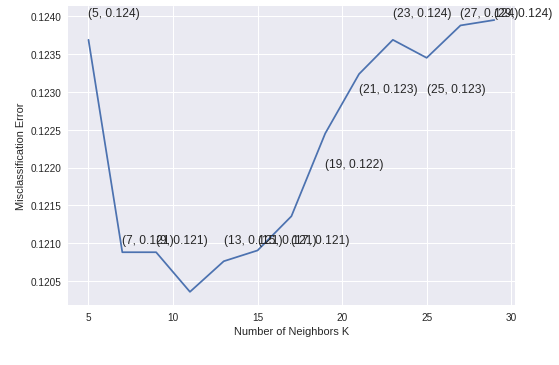

the misclassification error for each k value is :  [0.124 0.121 0.121 0.12  0.121 0.121 0.121 0.122 0.123 0.124 0.123 0.124
 0.124]


In [49]:
#finding optimal k
# creating odd list of K for KNN
myList = list(range(5,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 2-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_tr, y_tr, cv=2, scoring='f1_micro')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [50]:
#Performing KNN using bruteforce
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_tr,y_tr)
pred = knn.predict(X_test)
acc = f1_score(y_test, pred,average='micro') * float(100)
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 11 is 88.022222%


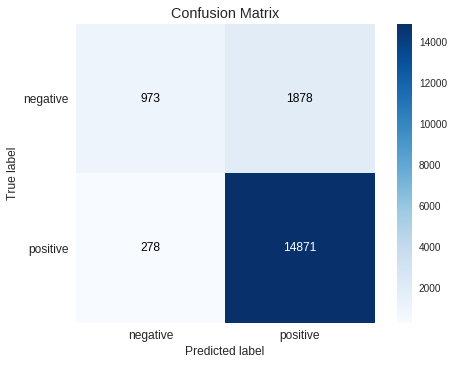

In [51]:
skplt.plot_confusion_matrix(y_test ,pred)

In [52]:
print(classification_report(y_test ,pred))

              precision    recall  f1-score   support

    negative       0.78      0.34      0.47      2851
    positive       0.89      0.98      0.93     15149

   micro avg       0.88      0.88      0.88     18000
   macro avg       0.83      0.66      0.70     18000
weighted avg       0.87      0.88      0.86     18000



# KNN on weighted TFIDF using KD_tree

In [0]:
X = final_data_kd_tree['CleanedText'].values
y = final_data_kd_tree.Score.values
X_tr, X_test, y_tr, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=0)
# split the train data set into cross validation train and cross validation test



In [58]:
i=0
list_of_sent=[]
for sent in X_tr:
    list_of_sent.append(sent.split())
    
i=0
list_of_sent_test=[]
for sent in X_test:
    list_of_sent_test.append(sent.split())
    
len(list_of_sent)

14000

In [0]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_tr)
tf2 = model.transform(X_test)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [61]:

X_tr =tfidf_sent_vectors
len(X_tr)

14000

In [0]:
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1  

In [63]:
X_test = tfidf_sent_vectors_test
len(X_test)

6000

In [0]:
X_tr = np.nan_to_num(X_tr)
X_test = np.nan_to_num(X_test)


The optimal number of neighbors is 11.


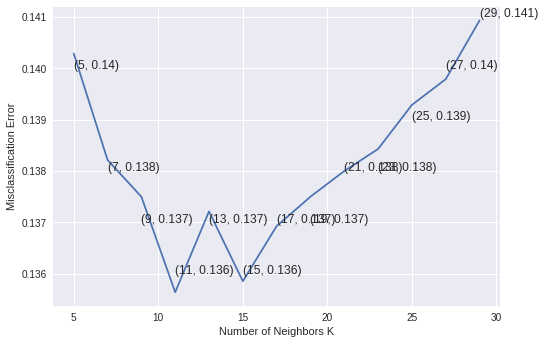

the misclassification error for each k value is :  [0.14  0.138 0.137 0.136 0.137 0.136 0.137 0.137 0.138 0.138 0.139 0.14
 0.141]


In [65]:
myList = list(range(5,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 2-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    scores = cross_val_score(knn, X_tr, y_tr, cv=2, scoring='f1_micro')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [66]:
#Performing KNN using kd-tree
knn = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
knn.fit(X_tr,y_tr)
pred = knn.predict(X_test)
acc = f1_score(y_test, pred,average='micro') * float(100)
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 11 is 84.066667%


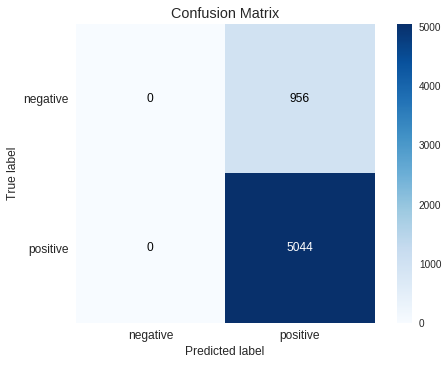

In [67]:
skplt.plot_confusion_matrix(y_test ,pred)

In [68]:
print(classification_report(y_test ,pred))

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       956
    positive       0.84      1.00      0.91      5044

   micro avg       0.84      0.84      0.84      6000
   macro avg       0.42      0.50      0.46      6000
weighted avg       0.71      0.84      0.77      6000



# KNN on weighted TFIDF using brute force

In [0]:
X = final_data['CleanedText'].values
y = final_data.Score.values
X_tr, X_test, y_tr, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=0)
# split the train data set into cross validation train and cross validation test


In [70]:
i=0
list_of_sent=[]
for sent in X_tr:
    list_of_sent.append(sent.split())
    
i=0
list_of_sent_test=[]
for sent in X_test:
    list_of_sent_test.append(sent.split())
    
len(list_of_sent)

42000

In [0]:
model = TfidfVectorizer()
tf1 = model.fit_transform(X_tr)
tf2 = model.transform(X_test)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1


In [73]:
X_tr = tfidf_sent_vectors
len(X_tr)

42000

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
          if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
          pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1


In [85]:
X_test = tfidf_sent_vectors
len(X_test)

18000

In [0]:
X_tr = np.nan_to_num(X_tr)
X_test = np.nan_to_num(X_test)


The optimal number of neighbors is 11.


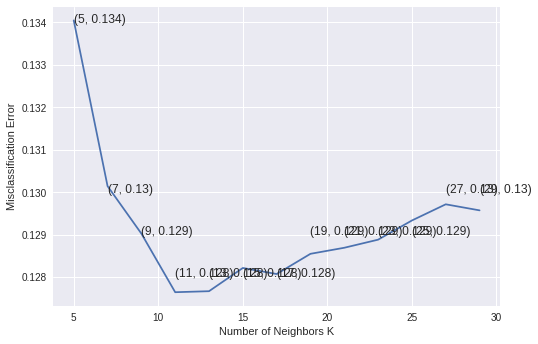

the misclassification error for each k value is :  [0.134 0.13  0.129 0.128 0.128 0.128 0.128 0.129 0.129 0.129 0.129 0.13
 0.13 ]


In [87]:
myList = list(range(5,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 2-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_tr, y_tr, cv=2, scoring='f1_micro')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [88]:
#Performing KNN using bruteforce
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_tr,y_tr)
pred = knn.predict(X_test)
acc = f1_score(y_test, pred,average='micro') * float(100)
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 11 is 86.988889%


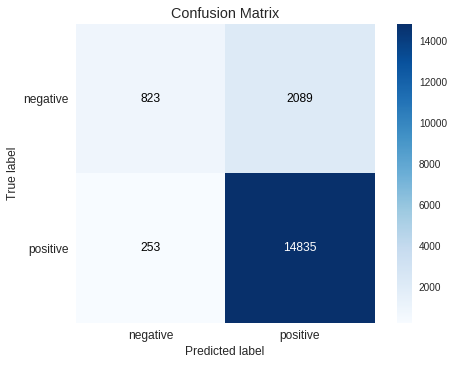

In [89]:
skplt.plot_confusion_matrix(y_test ,pred)

In [90]:
print(classification_report(y_test ,pred))

              precision    recall  f1-score   support

    negative       0.76      0.28      0.41      2912
    positive       0.88      0.98      0.93     15088

   micro avg       0.87      0.87      0.87     18000
   macro avg       0.82      0.63      0.67     18000
weighted avg       0.86      0.87      0.84     18000



In [0]:
!pip install -q PTable

In [0]:
from prettytable import PrettyTable

In [0]:
z = PrettyTable()
z.field_names = ["Vectorizer", "Model", "Hyperparameter k", "f1 score accuracy"]

In [95]:
#Final summary
z.add_row(["BoW", 'kd_tree', 29, '91.65%'])
z.add_row(["BoW", 'brute_force', 11, '91.66'])
z.add_row(["TF_IDF",'kd_tree', 23, '91.87%'])
z.add_row(["TF_IDF", 'brute_force', 9, '92.25%'])
z.add_row(["Avg W2V", 'kd_tree', 9, '87.18%'])
z.add_row(["Avg W2V", 'brute_force', 11, '88.02%'])
z.add_row(["TF_IDF weighted W2V",'kd_tree', 11, '84.06%'])
z.add_row(["TF_IDF weighted W2V", 'brute_force', 11, '86.98%'])
print(z)

+---------------------+-------------+------------------+-------------------+
|      Vectorizer     |    Model    | Hyperparameter k | f1 score accuracy |
+---------------------+-------------+------------------+-------------------+
|         BoW         |   kd_tree   |        29        |       91.65%      |
|         BoW         | brute_force |        11        |       91.66       |
|        TF_IDF       |   kd_tree   |        23        |       91.87%      |
|        TF_IDF       | brute_force |        9         |       92.25%      |
|       Avg W2V       |   kd_tree   |        9         |       87.18%      |
|       Avg W2V       | brute_force |        11        |       88.02%      |
| TF_IDF weighted W2V |   kd_tree   |        11        |       84.06%      |
| TF_IDF weighted W2V | brute_force |        11        |       86.98%      |
+---------------------+-------------+------------------+-------------------+


Conclusions:
Different size of data points were taken for kd_tree and brute force. Hence, the conclusion could be biased a bit.
Brute Force: 100k
Kd_tree: 20k
2 fold CV is used for both algorithms instead of simple CV

1)It takes more time to run kd_tree than brute force even after reducing the dimensions.But considering this set of points of about 100k for brute force, even this takes more time.

2)Knn on TFIDF Weighted avgw2v using kd_tree model is a dumb model,here. It actually predicted only the positive class,the majority class, even if it gives a good f1 accuracy of 84%. 

